In [2]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from datetime import datetime
pd.options.mode.chained_assignment = None  # default='warn'   pd.set_option('chained_assignment', None) also works

NOTE: Load the file that was downloaded from coursera. parse dates to allow datetime.

create a main pandas dataframe with the data.

In [3]:
file = 'Data-Collisions.csv'
parse_dates=['INCDATE','INCDTTM']


df_main = pd.read_csv(file,parse_dates=parse_dates,low_memory=False)
df_main.head(4)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N


NOTE: create a copy of the main dataframe to prevent overwriting.

dropped columns that are irrelevant to a model that predicts severity codes.

In [4]:
df=df_main.copy()
print(len(df))
#drop columns that will not add value to ML. Attributes had over 100k values missing. 
df.drop(columns={'OBJECTID','SEVERITYDESC','SDOT_COLCODE','INCKEY',
                 'COLDETKEY','REPORTNO','STATUS','INTKEY',
                 'EXCEPTRSNCODE','EXCEPTRSNDESC','INATTENTIONIND',
                 'SDOTCOLNUM','JUNCTIONTYPE','PEDROWNOTGRNT','SPEEDING',
                'SEGLANEKEY','CROSSWALKKEY','ST_COLCODE','SEVERITYCODE.1'},inplace=True)
# print(df.isna().sum())

194673


NOTE: added columns that specify the day, month, day/night, and season of the accident data.

In [5]:
# df.INCDATE=df.INCDATE.dt.normalize()
df['DAY'] = df.INCDTTM.dt.weekday
df['MONTH'] = df.INCDTTM.dt.month
df.DAY.replace([0,1,2,3,4,5,6],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],inplace=True)
df.MONTH.replace([1,2,3,4,5,6,7,8,9,10,11,12],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],inplace=True)

#determine if day or night
df.loc[(df.INCDTTM.dt.hour>=6) & (df.INCDTTM.dt.hour<18),'DAY/NIGHT']='Day'
df.loc[(df.INCDTTM.dt.hour>=18) & (df.INCDTTM.dt.hour<=24),'DAY/NIGHT']='Night'
df.loc[(df.INCDTTM.dt.hour>=0) & (df.INCDTTM.dt.hour<6),'DAY/NIGHT']='Night'

#determine the season
df.loc[(df.INCDTTM.dt.month==1)|(df.INCDTTM.dt.month==2)|(df.INCDTTM.dt.month==12),'SEASON']='Winter'
df.loc[(df.INCDTTM.dt.month==3)|(df.INCDTTM.dt.month==4)|(df.INCDTTM.dt.month==5),'SEASON']='Spring'
df.loc[(df.INCDTTM.dt.month==6)|(df.INCDTTM.dt.month==7)|(df.INCDTTM.dt.month==8),'SEASON']='Summer'
df.loc[(df.INCDTTM.dt.month==9)|(df.INCDTTM.dt.month==10)|(df.INCDTTM.dt.month==11),'SEASON']='Fall'

NOTE: clean up data. dropped missing data for critical attibutes and cleaned up attributes that had data meaning the same thing (e.g. 0 = N and 1 = Y). Since there was not distinguishable difference between Dark and with no street lights, lights off, or unknown lighting, they were all combined.

In [7]:
print('Total Number of Data Points before cleaning: ', len(df))
df=df[df.X.notna()]
df=df[df.Y.notna()]
df=df[df.SEVERITYCODE.notna()]
df=df[df.COLLISIONTYPE.notna()]
df=df[df.WEATHER.notna()]
df=df[df.ROADCOND.notna()]
df=df[df.LIGHTCOND.notna()]
df.drop(df[(df['SEVERITYCODE']=='0')].index,inplace=True)
df.drop(df[(df['WEATHER']=='Unknown')].index,inplace=True)
df.drop(df[(df['WEATHER']=='Other')].index,inplace=True)
df.drop(df[(df['ROADCOND']=='Unknown')].index,inplace=True)
df.drop(df[(df['ROADCOND']=='Other')].index,inplace=True)
df.drop(df[(df['LIGHTCOND']=='Unknown')].index,inplace=True)
df.drop(df[(df['LIGHTCOND']=='Other')].index,inplace=True)
#change 0,1 to N,Y for consistency
df.UNDERINFL.loc[df.UNDERINFL=='0']='N'
df.UNDERINFL.loc[df.UNDERINFL=='1']='Y'

#change dark lighting categories to a single dark with no lighting available.
df.LIGHTCOND.loc[df.LIGHTCOND=='Dark - No Street Lights']='Dark - No Lighting'
df.LIGHTCOND.loc[df.LIGHTCOND=='Dark - Street Lights Off']='Dark - No Lighting'
df.LIGHTCOND.loc[df.LIGHTCOND=='Dark - Unknown Lighting']='Dark - No Lighting'
#change 2b to a 2 (general injury) as selection of injury severity assumed to be subjective.
df.SEVERITYCODE.loc[df.SEVERITYCODE=='2b']='2'


df.reset_index(inplace=True)
print('Total Number of Data Points after cleaning: ', len(df))

Total Number of Data Points before cleaning:  166200
Total Number of Data Points after cleaning:  166200


In [8]:
df.groupby('SEVERITYCODE')['X'].count().sum()

166200

NOTE: clustered the data as there were ober 150k data points. this allows to better plot the data. clusters were created using kmeans from scipy.

In [9]:
# !conda install -c conda-forge folium=0.5.0 --yes
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import folium

seattle_geo = r'seattle.geojson' # geojson file


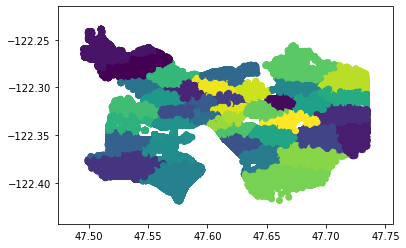

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten

coordinates= np.column_stack((df['Y'],df['X']))

x, label = kmeans2(whiten(coordinates), 40, iter = 20)  
plt.scatter(coordinates[:,0], coordinates[:,1], c=label);
plt.show()

In [9]:
label = pd.DataFrame(label)
df2=pd.concat((df,label),axis=1,ignore_index=False)
df2.rename(columns={0:'Cluster_Label'},inplace=True)

NOTE: labels were created for each cluster. perhaps there is a trend with accidents and the cluster they are in. maybe it is a highway or a highly populated area or tourist traffic area.

In [10]:
df_cluster=df2.groupby(['Cluster_Label']).agg({'X':'mean','Y':'mean','SEVERITYCODE':'count'})
df_cluster=df_cluster.rename(columns={'X':'Cluster_X','Y':'Cluster_Y','SEVERITYCODE':'Cluster_Count'})

df_cluster=df_cluster.reset_index()
df_cluster.head(2)

,Cluster_Label,Cluster_X,Cluster_Y,Cluster_Count
0,0,-122.307433,47.687267,2792
1,1,-122.346887,47.724038,4204


In [11]:
df4 = pd.merge(df2, df_cluster,
                        on=['Cluster_Label'], how='left')
df4.groupby('Cluster_Label')
df4.Cluster_Count.astype('str')
df4.head(4)

,index,SEVERITYCODE,X,Y,ADDRTYPE,LOCATION,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,...,ST_COLDESC,HITPARKEDCAR,DAY,MONTH,DAY/NIGHT,SEASON,Cluster_Label,Cluster_X,Cluster_Y,Cluster_Count
0,0,2,-122.323148,47.703140,Intersection,5TH AVE NE AND NE 103RD ST,Angles,2,0,0,...,Entering at angle,N,Wed,Mar,Day,Spring,27,-122.320785,47.715409,4695
1,1,1,-122.347294,47.647172,Block,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Sideswipe,2,0,0,...,From same direction - both going straight - bo...,N,Wed,Dec,Night,Winter,34,-122.350728,47.654899,5883
2,2,1,-122.334540,47.607871,Block,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Parked Car,4,0,0,...,One parked--one moving,N,Thu,Nov,Day,Fall,32,-122.336413,47.608916,9431
3,3,1,-122.334803,47.604803,Block,2ND AVE BETWEEN MARION ST AND MADISON ST,Other,3,0,0,...,From same direction - all others,N,Fri,Mar,Day,Spring,32,-122.336413,47.608916,9431


In [12]:
# create a plain world map
#https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps
seattle_coord = (47.6062, -122.3321)

seattle_map = folium.Map(location=seattle_coord, zoom_start=12)

coord = np.column_stack((df4.groupby('Cluster_Label')['Cluster_Y'].median().tolist(),
                         df4.groupby('Cluster_Label')['Cluster_X'].median().tolist()))

marker_cluster = MarkerCluster().add_to(seattle_map)

for point in range(len(coord)):
    folium.Marker(coord[point]).add_to(marker_cluster)
seattle_map.save('seattle_map.html')
seattle_map


NOTE: plot the data to show imbalance of data.

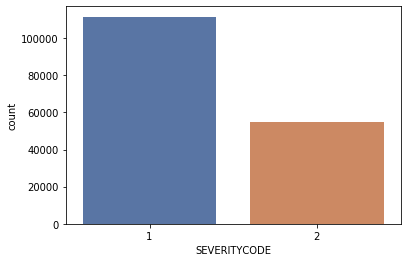

In [13]:
plt1 = sns.countplot(x=df4.SEVERITYCODE, palette = 'deep',data=df)

NOTE: create a features and labels dataframe for ML models and for imblearn to oversample/under sample data.

In [14]:
Features = df4[['ADDRTYPE','COLLISIONTYPE','PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT','SDOT_COLDESC', 'UNDERINFL',
                'WEATHER','ROADCOND', 'LIGHTCOND', 'ST_COLDESC', 'HITPARKEDCAR']]
Labels = df4.SEVERITYCODE.values

In [15]:
X = Features
y = Labels

In [72]:
#over sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
# #under sampling
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(X, y)

NOTE: plot data after re-sampling

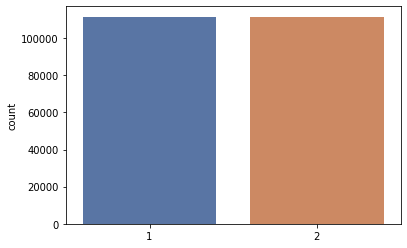

In [73]:
plt1 = sns.countplot(x=y_resampled, palette = 'deep',data=df)

NOTE: encode the re-sampled data to change categorical data into numerical data for ML models.

In [74]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
Features_encoded = pd.DataFrame()
for col in Features.columns:
    encoded = le.fit_transform(Features[col])
    Features_encoded = pd.concat([Features_encoded,pd.Series(encoded, name=col)], axis=1)
    
    

In [75]:
X = Features_encoded
y = Labels

# ML models

NOTE: import all necessary packages

In [76]:

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

import sklearn

from sklearn import preprocessing, datasets, metrics
#import sklearn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


#import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, jaccard_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix




NOTE: split the data into training and testing datasets

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (116340, 13) (116340,)
Test set: (49860, 13) (49860,)


# K Nearest Neighbor(KNN)

NOTE: find optimal K and run KNN model on training and testing datasets

In [78]:
Ks = 8
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):

    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
#      
print( "The best KNN accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

k = mean_acc.argmax()+1

neigh = KNeighborsClassifier(n_neighbors = k)
neigh.fit(X_train,y_train)

The best KNN accuracy was with 0.7241075010028079 with k= 6


KNeighborsClassifier(n_neighbors=6)

# Decision Tree

In [79]:

dtree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dtree.fit(X_train,y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=4)

# Logistic Regression

In [80]:

LR = LogisticRegression(C=0.01, solver='liblinear')
LR.fit(X_train,y_train)

LogisticRegression(C=0.01, solver='liblinear')

# Naive Bayes

In [81]:

# fit a Naive Bayes model to the data
NB = GaussianNB()
NB.fit(X_train, y_train)

GaussianNB()

# Random Forest

In [82]:

RNDF = RandomForestClassifier()
RNDF.fit(X_train, y_train)


RandomForestClassifier()

# Model Evaluation using Test set

NOTE: create a report that compares several model metrics

In [83]:
yhat_test = neigh.predict(X_test)
yhat_dtree_test = dtree.predict(X_test)
yhat_LR_test = LR.predict(X_test) 
yhat_NB_test = NB.predict(X_test)
yhat_RNDF_test = RNDF.predict(X_test)

In [84]:
report = pd.DataFrame(columns=['Jaccard','F1-score','Recall','Precision'], index = ['K Neighbors','DecisionTree','LogisticRegression','Naive Bayes','Random Forest'])

In [85]:
#evaluations
from sklearn.metrics import jaccard_score
report['Jaccard'][0] = jaccard_score(y_test, yhat_test)
report['Jaccard'][1] = jaccard_score(y_test, yhat_dtree_test)
report['Jaccard'][2] = jaccard_score(y_test, yhat_LR_test)
report['Jaccard'][3] = jaccard_score(y_test, yhat_NB_test)
report['Jaccard'][4] = jaccard_score(y_test, yhat_RNDF_test)

report['F1-score'][0] = f1_score(y_test,yhat_test,average='weighted')
report['F1-score'][1] = f1_score(y_test,yhat_dtree_test,average='weighted')
report['F1-score'][2] = f1_score(y_test,yhat_LR_test,average='weighted')
report['F1-score'][3] = f1_score(y_test,yhat_NB_test,average='weighted')
report['F1-score'][4] = f1_score(y_test,yhat_RNDF_test,average='weighted')

report['Recall'][0] = recall_score(y_test,yhat_test,average='weighted')
report['Recall'][1] = recall_score(y_test,yhat_dtree_test,average='weighted')
report['Recall'][2] = recall_score(y_test,yhat_LR_test,average='weighted')
report['Recall'][3] = recall_score(y_test,yhat_NB_test,average='weighted')
report['Recall'][4] = recall_score(y_test,yhat_RNDF_test,average='weighted')

report['Precision'][0] = precision_score(y_test,yhat_test,average='weighted')
report['Precision'][1] = precision_score(y_test,yhat_dtree_test,average='weighted')
report['Precision'][2] = precision_score(y_test,yhat_LR_test,average='weighted')
report['Precision'][3] = precision_score(y_test,yhat_NB_test,average='weighted')
report['Precision'][4] = precision_score(y_test,yhat_RNDF_test,average='weighted')


report

,Jaccard,F1-score,Recall,Precision
K Neighbors,0.689362,0.694387,0.724108,0.71193
DecisionTree,0.706268,0.659339,0.72509,0.768958
LogisticRegression,0.704081,0.673087,0.727056,0.744422
Naive Bayes,0.69427,0.663835,0.717369,0.72101
Random Forest,0.692533,0.705986,0.730525,0.718708


NOTE: plot matrices for the various models to determine performance.

K Neighbors
[[41428     0]
 [    0  8432]]


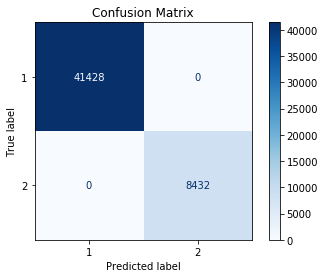

In [86]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix

disp = plot_confusion_matrix(neigh, X_test, yhat_test,
                             cmap=plt.cm.Blues,normalize=None)
disp.ax_.set_title('Confusion Matrix')

print('K Neighbors')
print(disp.confusion_matrix)

plt.show()



dtree
[[41330    98]
 [ 4911  3521]]


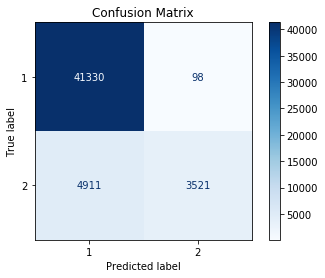

In [87]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix

disp = plot_confusion_matrix(dtree, X_test, yhat_test,
                             cmap=plt.cm.Blues,normalize=None)
disp.ax_.set_title('Confusion Matrix')

print('dtree')
print(disp.confusion_matrix)

plt.show()

Logistic Regression
[[40477   951]
 [ 4510  3922]]


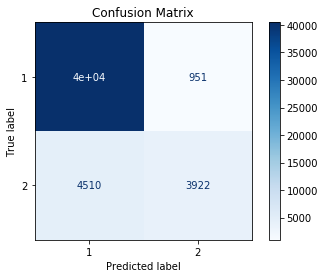

In [88]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix

disp = plot_confusion_matrix(LR, X_test, yhat_test,
                             cmap=plt.cm.Blues,normalize=None)
disp.ax_.set_title('Confusion Matrix')

print('Logistic Regression')
print(disp.confusion_matrix)

plt.show()

Naive Bayes
[[40181  1247]
 [ 4531  3901]]


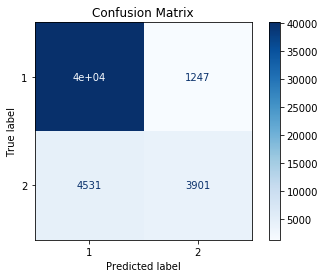

In [89]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix

disp = plot_confusion_matrix(NB, X_test, yhat_test,
                             cmap=plt.cm.Blues,normalize=None)
disp.ax_.set_title('Confusion Matrix')

print('Naive Bayes')
print(disp.confusion_matrix)

plt.show()

Random Forest
[[38061  3367]
 [ 2519  5913]]


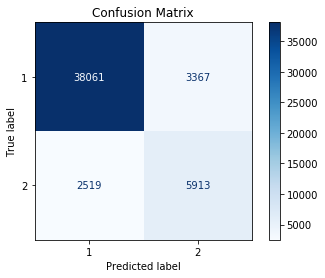

In [90]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix

disp = plot_confusion_matrix(RNDF, X_test, yhat_test,
                             cmap=plt.cm.Blues,normalize=None)
disp.ax_.set_title('Confusion Matrix')

print('Random Forest')
print(disp.confusion_matrix)

plt.show()